## **Rooftop Detection with Sattelite Pictures using U-Net**
**base library : Py-torch**

In [1]:
BASE_DIR = '/content/drive/MyDrive/rooftop_detection/'
DATA_DIR = f'{BASE_DIR}dataset/'
print(DATA_DIR)

/content/drive/MyDrive/rooftop_detection/dataset/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/rooftop_detection/"
!pwd

/content/drive/MyDrive/rooftop_detection
/content/drive/MyDrive/rooftop_detection


**Import library**

In [4]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 16.3 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=e754b49881597e3a78d8ee88cce0cd22e163093cf1abfca3aa8b232b2bfbe159
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [33]:
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F

from PIL import Image
import numpy as np
import glob
import os
import albumentations
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Analyze dataset**

In [6]:
class RooftopDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_file = sorted(glob.glob(os.path.join(image_dir, '*.png')))
        self.mask_file = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
        print(self.image_file)
        print(len(self.image_file))
        print(len(self.mask_file))

    def __len__(self):
        return len(self.image_file)

    def __getitem__(self, index):
        image = np.array(Image.open(self.image_file[index]).convert("RGB"))
        mask = np.array(Image.open(self.mask_file[index]).convert("L"), dtype=np.float32)
        mask[mask > 0.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image, mask


**Load dataset**

In [7]:
train_image_folder = f'{DATA_DIR}train/'
train_mask_folder = f'{DATA_DIR}train_labels/'

test_image_folder = f'{DATA_DIR}test/'
test_mask_folder = f'{DATA_DIR}test_labels/'

In [8]:
test_image_folder

'/content/drive/MyDrive/rooftop_detection/dataset/test/'

In [9]:
transform_train = albumentations.Compose([
    albumentations.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    albumentations.Rotate(limit=35, p=1.0),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.1),
    albumentations.pytorch.ToTensor()
])

transform = albumentations.Compose([
    albumentations.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    albumentations.pytorch.ToTensor()
])

train_set = RooftopDataset(train_image_folder, train_mask_folder, transform)
test_set = RooftopDataset(test_image_folder, test_mask_folder, transform)

train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
 
print(train_set[0][0].shape, train_set[0][1].shape)
print(len(train_loader), len(test_loader))

['/content/drive/MyDrive/rooftop_detection/dataset/train/121.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/241.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/270.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/272.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/274.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/278.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/284.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/287.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/300.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/301.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/303.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/308.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/314.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/315.png', '/content/drive/MyDrive/rooftop_detection/dataset/train/317.png', '/content

**Preview dataset**

torch.Size([256, 256, 3])


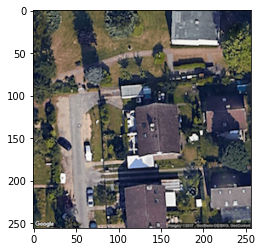

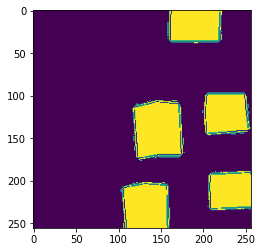

In [10]:
img, label = train_set[0]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
print(img.shape)
plt.imshow(img)
plt.show()
label = label.swapaxes(0,1)
label = label.swapaxes(1,2)
plt.imshow(label[:,:,0])
plt.show()

**Build UNET**

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

**Loss Function : Cross Entropy Loss + ِDice Loss**

In [41]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def cross_entropy_loss(preds, targets, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(preds, targets)
    preds = F.sigmoid(preds)
    dice = dice_loss(preds, targets)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    return loss

**Measure Unit : Accuracy**

In [26]:
import math
def accuracy(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    TN = np.sum(np.logical_and(pred == 0, target == 0))
    FP = np.sum(np.logical_and(pred == 1, target == 0))
    FN = np.sum(np.logical_and(pred == 0, target == 1))
    if (TP + FP + TN + FN) == 0: return 0
    else: return (TP + TN)/(TP + FP + TN + FN)

**Train epoch**

In [42]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)
    model.train()
    running_loss = []
    for batch_idx, (image, mask) in enumerate(loop):
        image = image.to(device)
        mask = mask.float().to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            predict = model(image)
            loss = loss_fn(predict, mask)
            loss.backward()
            running_loss.append(loss.item())
            optimizer.step()
        loop.set_postfix(last_loss=loss.item())
    print()    
    print(f"average_loss={np.mean(running_loss):.4f}", end="")

**Test epoch**

In [15]:
def test_fn(loader, model, device):
    with torch.no_grad():
        running_accuracy = []
        model.eval()
        for batch_idx, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)

            for i in range(images.shape[0]):
                prediction = torch.sigmoid(model(torch.unsqueeze(images[i], 0)))
                preds = (prediction > 0.5).float().detach().cpu().numpy()
                mask = labels[i].detach().cpu().numpy()
                running_accuracy.append(accuracy(preds, mask))

    print(f"accuracy={np.mean(running_accuracy):.4f}")
    return (np.mean(running_accuracy))
    

**Train model (UNET)**

In [43]:
model_baseline = UNET(in_channels=3, out_channels=1).to(device)
loss_fn_baseline = cross_entropy_loss
optimizer = optim.Adam(params=model_baseline.parameters(), lr=0.0001)

for epoch in range(10):
    print('Epoch', epoch)   
    train_fn(train_loader, model_baseline, optimizer, loss_fn_baseline)
    out_acc = test_fn(test_loader, model_baseline, device)

Epoch 0


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 13/13 [00:01<00:00, 10.24it/s, last_loss=0.612]


average_loss=0.6619

accuracy=0.8664
Epoch 1


100%|██████████| 13/13 [00:01<00:00, 11.15it/s, last_loss=0.472]


average_loss=0.5532

accuracy=0.8249
Epoch 2


100%|██████████| 13/13 [00:01<00:00, 11.35it/s, last_loss=0.485]


average_loss=0.5044

accuracy=0.8556
Epoch 3


100%|██████████| 13/13 [00:01<00:00, 11.14it/s, last_loss=0.433]


average_loss=0.4616

accuracy=0.8552
Epoch 4


100%|██████████| 13/13 [00:01<00:00, 11.33it/s, last_loss=0.462]


average_loss=0.4425

accuracy=0.8520
Epoch 5


100%|██████████| 13/13 [00:01<00:00, 11.12it/s, last_loss=0.427]


average_loss=0.4401

accuracy=0.8154
Epoch 6


100%|██████████| 13/13 [00:01<00:00, 11.09it/s, last_loss=0.41]



average_loss=0.4130accuracy=0.8949
Epoch 7


100%|██████████| 13/13 [00:01<00:00, 10.99it/s, last_loss=0.44]


average_loss=0.4094

accuracy=0.8776
Epoch 8


100%|██████████| 13/13 [00:01<00:00, 10.75it/s, last_loss=0.361]


average_loss=0.3895

accuracy=0.8106
Epoch 9


100%|██████████| 13/13 [00:01<00:00, 11.22it/s, last_loss=0.39]


average_loss=0.3797

accuracy=0.8785


**Test some picture**

U-Net

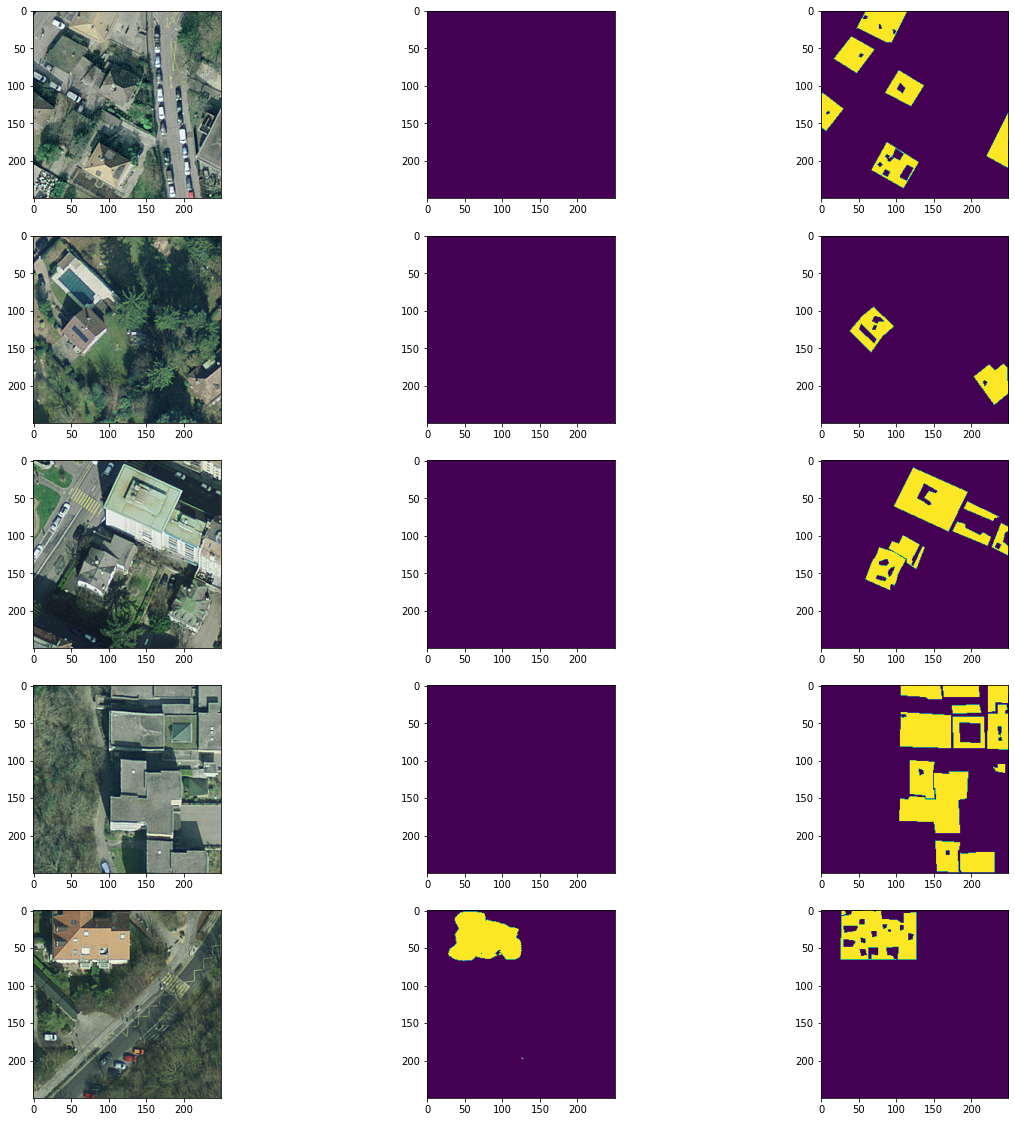

In [44]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))

for img, label in test_loader:
    cnt += 1
    
    temp = img[0].swapaxes(0,1)
    temp = temp.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(temp)
   
    
    preds = model_baseline(img.to(device))
    preds = (preds > 0.5).float()
    temp2 = preds[0].swapaxes(0,1)
    temp2 = temp2.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(temp2[:,:,0].cpu().detach().numpy())

    temp1 = label[0].swapaxes(0,1)
    temp1 = temp1.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+3)
    plt.imshow(temp1[:,:,0])

    if cnt == 5: break
plt.show()    

**Test Orginal Test Set**

In [45]:
# Preparing Data
class Test_NO_Label_Dataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_file = sorted(glob.glob(os.path.join(image_dir, '*.png')))
        print(self.image_file)
        print(len(self.image_file))

    def __len__(self):
        return len(self.image_file)

    def __getitem__(self, index):
        image = np.array(Image.open(self.image_file[index]).convert("RGB"))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations['image']

        return image

In [ ]:
# Addressing 
test_no_label_folder = f'{DATA_DIR}NO_LABEL_TEST/'

# Preparing data
test_no_label_set = Test_NO_Label_Dataset(test_no_label_folder, transform)
test_no_label_loader = DataLoader(test_no_label_set, batch_size=1, shuffle=False, num_workers=2)

['/content/drive/MyDrive/rooftop_detection/dataset/NO_LABEL_TEST/535.png', '/content/drive/MyDrive/rooftop_detection/dataset/NO_LABEL_TEST/537.png', '/content/drive/MyDrive/rooftop_detection/dataset/NO_LABEL_TEST/539.png', '/content/drive/MyDrive/rooftop_detection/dataset/NO_LABEL_TEST/551.png', '/content/drive/MyDrive/rooftop_detection/dataset/NO_LABEL_TEST/553.png']
5


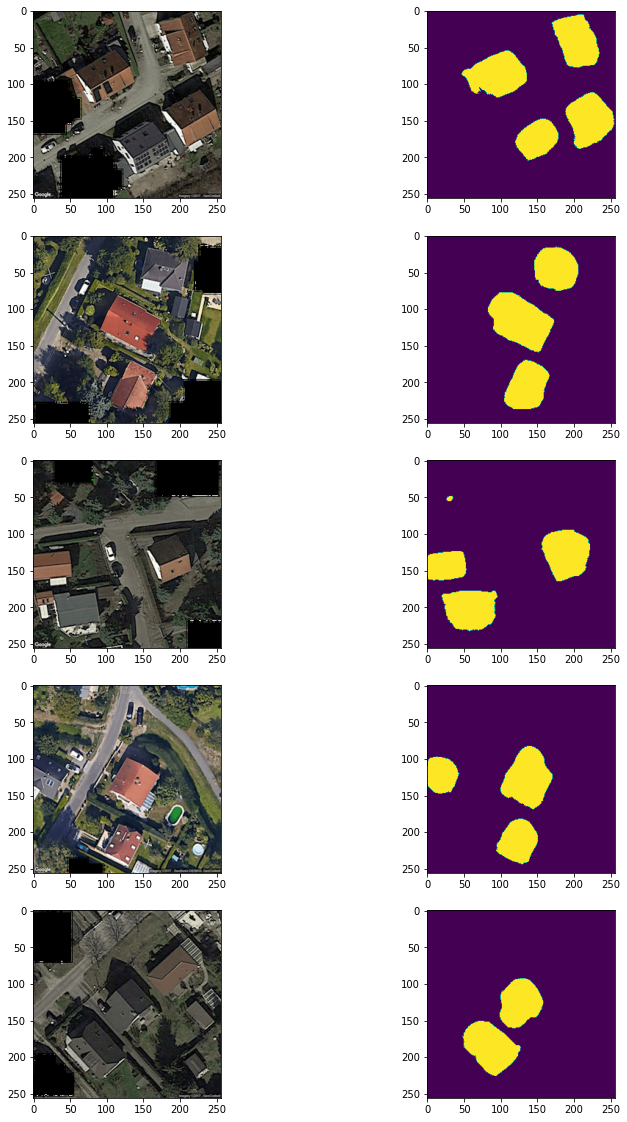

In [40]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))

for img in test_no_label_loader:
    cnt += 1
    
    temp = img[0].swapaxes(0,1)
    temp = temp.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(temp)
    
    preds = model_baseline(img.to(device))
    preds = (preds > 0.5).float()
    temp2 = preds[0].swapaxes(0,1)
    temp2 = temp2.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(temp2[:,:,0].cpu().detach().numpy())

    if cnt == 5: break
plt.show()  